# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/
!ls

# Libraries

In [ ]:
import os
import sys

from astropy.io import fits
from astropy    import units as u

import numpy as np
import pandas as pd

import time
import math
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
from torch.utils.data import Dataset, DataLoader


from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cuda
device_count:  1
Torch version:  2.5.0+cu121
torch.version.cuda:  12.1
Is CUDA enabled? True


# Paths

In [ ]:
base_path = Path('/Colab Notebooks/ML/')

maghi_path            = base_path / 'maghi'
training_process_path = maghi_path / 'train'
checkpoint_path       = training_process_path / 'checkpoints'
pred_path             = training_process_path / 'pred'



data_path = base_path / 'data'

saury_data_path = data_path / 'saury'
seta_data_path = data_path / 'seta'

# Fcn

In [ ]:
def save_csv(trial_valid_err, trial_test_err, trial_filename, process_train_err, process_validate_err, process_test_err, training_process_filename):
    """
        save_csv: save CSV files.

        input Attributes
        ----------
        trial_valid_err : list/array
            the validation performance in each trail.
        trial_test_err: list/array
            the testing performance in each trail.
        trial_filename: String
            csv file name for storing the testing and validation data.


        process_train_err : list/array
            train err of each epoch.
        process_validate_err : list/array
            validating err of each epoch.
        process_test_err : list/array
            testing err of each epoch.
        training_process_filename:  String
            csv file name for storing the process data.
    """
    ntrials = len(trial_valid_err)
    nepochs = len(process_train_err) // ntrials

    # Create an array containing numbers from 0 to nepochs
    numbers = np.arange(nepochs)

    # Repeat the array 'ntrials' times
    epochs = np.tile(numbers, ntrials)

    # Save error for trials
    df = pd.DataFrame({'valid_err' : trial_valid_err, 'test_err' : trial_test_err})
    df.to_csv(trial_filename, index=False)

    # Save errors for all epoch
    df = pd.DataFrame({'epoch' : epochs, 'train_err' : process_train_err, 'valid_err' : process_validate_err, 'test_err' : process_test_err})
    df.to_csv(training_process_filename, index=False)

    return None

In [ ]:
def plot(x, y, z, title, imgpath):
    # Plot
    plt.figure(figsize=(7,5))
    plt.title(title)
    plt.plot(x, 'k-', label='Training RMSE')
    plt.plot(y, 'k-.', label='Validation RMSE')
    plt.plot(z, 'b-', label='Testing RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()

    plt.savefig(imgpath, dpi=128, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [ ]:
def reshape_data(xcube, ymaps):
    """
    Reshape data

    xcube: np array
    ymaps: list of np arrays

    return:
    xcube_arr: np array
    ymap_arr: list of np arrays
    """
    nchan, ny, nx = xcube.shape
    dataset_size = nx * ny
    print(nchan, ny, nx)

    ylen = len(ymaps)

    xcube_arr = np.zeros((dataset_size, nchan))
    for k, (ix, jy) in enumerate(np.ndindex(nx, ny)):
        xcube_arr[k, :] = xcube[:, ix, jy]


    ymap_arr = np.zeros((dataset_size, ylen))
    for m, ymap in enumerate(ymaps):
        for k, (ix, jy) in enumerate(np.ndindex(nx, ny)):
            ymap_arr[k, m] = ymap[ix, jy]

    return xcube_arr, ymap_arr

In [ ]:
def load_weights(model, checkpoint_file):
    """
    Load check point

    Parameters:


    Returns:
      -
    """

    print('Checkpoint file: ', checkpoint_file)

    try:
        if checkpoint_file.is_file():
            checkpoint = torch.load(checkpoint_file, map_location=device)
            model.load_state_dict(checkpoint['net'])
            model.to(device)
            model.eval()

            print('sucessfully load the weights!')
        else:
            print("The file does not exist.")
            print(checkpoint_file)
    except Exception as e:
        print("An error occurred while reading the file:", e)

    return model

# Data loader

In [ ]:
# data loader
class SpecDataset(Dataset):
    """
    A class to represent Spectral Data.

    ...

    Attributes
    ----------
    x : numpy array
        Input data
    y : numpy array
        label data
    pev : str
        Positional encoding method
    xtransform : object
        Transform method for input data
    ytransform : object
        Transform method for label data

    Methods
    -------
    get_pe():
        Get positional encoding method.

    func1():
        method 1.

    func2():
        Method 2.
    """
    def __init__(self, x, y, pev, xtransform=None, ytransform=None):
        lenx, input_column = x.shape
        self.x = x
        self.y = y
        self.xtransform = xtransform
        self.ytransform = ytransform

        self.pev = pev
        self.input_column = input_column

        self.get_pe()



    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx, :] # shape: (nbatch, nchan)
        y = self.y[idx]    # shape: (2 or 3)

        # Positional encoding
        x = self.pe_fcn(x)

        if self.xtransform:
            x = self.xtransform(np.asarray(x, dtype = 'float32'))

        if self.ytransform:
            y = self.ytransform(np.asarray(y, dtype = 'float32'))

        return x, y




    def pe_index_concate(self, spec):
        pos  = np.linspace(0, 1., self.input_column).reshape(1, -1)
        spec = np.vstack((spec, pos))
        spec = spec.reshape(1, 2, self.input_column)
        return spec

    def pe_index_add(self, spec):
        pos   = np.linspace(0, 1., self.input_column).reshape(1, -1)
        spec  = spec + pos
        spec  = spec.reshape(1, 1, self.input_column)
        return spec

    def pe_sin_add(self, spec):
        pos  = np.sin(np.linspace(0, 1., self.input_column).reshape(1, -1))
        spec = spec + pos
        spec = spec.reshape(1, 1, self.input_column)
        return spec

    def pe_sin_concate(self, spec):
        pos  = np.sin(np.linspace(0, 1., self.input_column).reshape(1, -1))
        spec = np.vstack((spec, pos))
        spec = spec.reshape(1, 2, self.input_column)
        return spec

    def pe_poly_concate(self, spec):
        spec = np.vstack((spec, spec**2))
        spec = spec.reshape(1, 2, self.input_column)
        return spec


    def pe_original_vector(self, spec):
        return spec.reshape(1, 1, self.input_column)


    def get_pe(self):
        pes = {
            'index_concate'   : self.pe_index_concate,
            'index_add'       : self.pe_index_add,
            'sin_concate'     : self.pe_sin_concate,
            'sin_add'         : self.pe_sin_add,
            'poly_concate'    : self.pe_poly_concate,
            'original_vector' : self.pe_original_vector,
            'trainable_add'   : self.pe_original_vector
        }

        self.pe_fcn = pes.get(self.pev)


# Add transformations here
class ToTensor():
    """
    A class to perform tensor transformation.

    ...

    Attributes
    ----------
    None


    Methods
    -------
    __call__(sample):
        Transform data to tensor.
    """
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

# Parent Models

In [ ]:
"""
@author: Haiyang.Tang

Transformer Positional Encoder

    PositionalEncoding: positional encoding method in original natural language processing.

    Methods
    -------
    forward(x):
        add positional encoding to x and return x.
"""
class PE(nn.Module):
    def __init__(self, num_features, sequence_len=6, d_model=9):
        super(PE, self).__init__()

        pe     = torch.zeros((1, sequence_len, d_model), dtype=torch.float32)
        factor = -math.log(10000.) / d_model  # outs loop

        for index in range(0, sequence_len):  # position of word in seq
            for i in range(0, d_model, 2):
                div_term = math.exp(i * factor)
                pe[0, index, i] = math.sin(index * div_term)
                if (i+1 < d_model):
                    pe[0, index, i+1] = math.cos(index * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x





class CustomLoss(nn.Module):
    """
    A class to customize a loss function

    ...

    Attributes
    ----------
    weights : list
        Weights for each label


    Methods
    -------
    forward(preds, targets):
        Compute the loss.
    """
    def __init__(self, weights=[1., 1.]):
        super(CustomLoss, self).__init__()
        self.weights = weights
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.npars = len(weights)

    def forward(self, preds, targets):
        total_loss = 0.
        for i in range(self.npars):
            loss_yi = self.mse(preds[:, i], targets[:, i])
            total_loss += self.weights[i] * loss_yi
        # End - for

        return total_loss

In [ ]:
class Models(nn.Module):
    """
    A class to represent (parent) Models.

    ...

    Attributes
    ----------
    batch_size : int
        batch size
    lr : float
        learning rate

    pev : str
        Positional encoding method

    num_output : int
        Number of output lables

    input_column : int
        Number of input columns (number of velocity channels)

    dropout : float (0,1)
        Percentage of dropout

    device : str
        device

    checkpoint_path : str
        Path to checkpoint file (to save models)

    prefix : str
        prefix string for checkpoint file name


    Methods
    -------
    fit():
        Run the training process.

    trial_validate():
        Validate the model at the end of a run (or trial)

    epoch_train():
        Train the model at the end of an epoch.

    epoch_validate():
        validate the model.

    test():
        Test model.

    load_weights():
        Load check point file (.pth file)

    get_output_size():
        Calc. output size

    get_lpe():
        Get positional encoding method.

    get_input_row():
        Get input row.
    """
    def __init__(self, pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr):
        super(Models, self).__init__()

        self.batch_size = batch_size
        self.lr = lr

        self.pev = pev
        self.prefix = prefix

        self.num_output   = num_output
        self.in_channels  = 1
        self.input_column = input_column
        self.dropout      = dropout
        self.device       = device

        self.input_row = self.get_input_row() # 1 or 2 (concate)
        self.lpe = self.get_lpe()

        self.loss_fcn = CustomLoss(weights=[1., 1.])

        self.best_run_valid_loss = 99_999_999.
        self.checkpoint_path = checkpoint_path



    def get_lpe(self):
        if self.pev == 'trainable_add':
            return True

        return False





    def get_input_row(self):
        if self.pev in ['index_concate', 'sin_concate', 'poly_concate']:
            return 2

        return 1






    def load_weights(self, checkpoint_path):
        """
        Load check point file (.pth file)

        Parameters:


        Returns:
         -
        """

        print('Checkpoint file: ', checkpoint_path)

        try:
            if checkpoint_path.is_file():
                checkpoint = torch.load(checkpoint_path, map_location=self.device)
                self.load_state_dict(checkpoint['net'])
                self.to(self.device)
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                # epoch = checkpoint['epoch']
                self.eval()

                print('sucessfully load the weights!')
            else:
                print('The file does not exist.')
                print(checkpoint_path)
        except Exception as e:
            print('An error occurred while reading the file:', e)



    # Calc. output size
    def get_output_size(self, Hin, Win, k = [3, 3], s = [1, 1], p = [0, 0], d = [1, 1]):
        return int((Hin + 2*p[0] - d[0]*(k[0] - 1)/s[0] - 1) + 1), int((Win + 2*p[1] - d[1]*(k[1] - 1)/s[1] - 1) + 1)


    def get_output_size_1D(self, Lin, k = 3, s = 1, p = 0, d = 1):
        return int((Lin + 2*p - d*(k - 1) - 1)/s + 1)




    def testing(self, x, y):
        '''
        Run the test on test set after training
        '''

        # Test mode
        self.eval()

        # To CPU/GPU
        self.to(self.device)

        nspecs, nchane = x.shape
        nspecs, npar = y.shape

        print('xtest shape ', nspecs, nchane)
        print('ytest shape ', nspecs, npar)
        print('Number of spectra: ', nspecs)

        dataset_test     = SpecDataset(x, y, self.pev, xtransform=ToTensor(), ytransform=ToTensor())
        self.test_loader = DataLoader(dataset = dataset_test,  batch_size = self.batch_size, shuffle = False)

        for (a,b) in self.test_loader:
            print('Input shape: ', a.shape, ', Output shape: ', b.shape)
            break


        in_channels = a.shape[1] # 1 adding
        input_row   = a.shape[2] # 2 concat
        print('in_channels, input_row: ', in_channels, input_row)

        nchunks = (nspecs // self.batch_size)
        klastspecs = nspecs % self.batch_size

        test_loss = 0.
        ypred = np.zeros((nspecs, npar))
        i = 0
        with torch.no_grad():
            for idx, (x, y) in enumerate(self.test_loader):
                x = x.float()
                y = y.float()
                x = x.to(self.device)
                y = y.to(self.device)

                # forward
                ret  = self(x)
                loss = self.loss_fcn(ret, y)
                test_loss += loss.item()

                kspecs = self.batch_size if (i < nchunks) else klastspecs
                ypred[i*self.batch_size : (i*self.batch_size + kspecs), :] = ret.cpu().numpy()

                i += 1
            # End - for
        # End - with

        # Average loss
        avg_test_loss = np.sqrt(test_loss / len(self.test_loader))
        return avg_test_loss, ypred







    def predict(self, x, npars=3):
        '''
        Run the test on test set after training
        '''

        # load the best model from a run (with n epochs)
        self.optimizer = optim.SGD(self.parameters(), self.lr)
        checkpnt_file = self.checkpoint_path / f'{self.prefix}_{self.pev}_final.pth'
        print('Loading...')
        print('Checkpoint file: ', checkpnt_file)
        self.load_weights(checkpnt_file)

        # Test mode
        self.eval()

        # To CPU/GPU
        self.to(self.device)

        nspecs, nchane = x.shape

        print('xtest shape ', nspecs, nchane)
        print('Number of spectra: ', nspecs)

        ypred = np.zeros((nspecs, npars))

        dataset_test = SpecDataset(x, ypred, self.pev, xtransform=ToTensor(), ytransform=ToTensor())
        xloader = DataLoader(dataset = dataset_test,  batch_size = self.batch_size, shuffle = False)

        for (a,b) in xloader:
            print('Input shape: ', a.shape, ', Output shape: ', b.shape)
            break


        in_channels = a.shape[1] # 1 adding
        input_row   = a.shape[2] # 2 concat
        print('in_channels, input_row: ', in_channels, input_row)

        nchunks = (nspecs // self.batch_size)
        klastspecs = nspecs % self.batch_size

        i = 0
        with torch.no_grad():
            for idx, (x, _) in enumerate(xloader):
                x = x.float()
                x = x.to(self.device)

                # forward
                ret  = self(x)

                kspecs = self.batch_size if (i < nchunks) else klastspecs
                ypred[i*self.batch_size : (i*self.batch_size + kspecs), :] = ret.cpu().numpy()

                i += 1
            # End - for
        # End - with

        return ypred


    def trial_validate(self):
        """
        Validate the model at the end of a run (or trial)

        Parameters
        ----------
        pev: String
            positional encoding vector method, used for naming the weights file.
        epoch : int.
            the index of epoch.

        Returns
        -------
        error: The mean MSE in validation set.

        """

        # load the best model from a run (with n epochs)
        self.load_weights(self.checkpoint_path / f'{self.prefix}_{self.pev}.pth')

        # Test/valid mode
        self.eval()

        valid_loss = 0.
        with torch.no_grad():
            for idx, (x, y) in enumerate(self.valid_loader):
                x = x.float()
                y = y.float()
                x = x.to(self.device)
                y = y.to(self.device)

                # forward
                ret  = self(x)
                loss = self.loss_fcn(ret, y)
                valid_loss += loss.item()
            # End - for
        # End - with

        # Save checkpoint.
        avg_valid_loss = np.sqrt(valid_loss / len(self.valid_loader))

        if avg_valid_loss < self.best_run_valid_loss:
            print('Best final RMSE err: ', avg_valid_loss, 'Saving..')
            state = {'net': self.state_dict(),
                    'err': avg_valid_loss,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': 0
                    }

            torch.save(state, self.checkpoint_path / f'{self.prefix}_{self.pev}_final.pth')
            self.best_run_valid_loss = avg_valid_loss
        #End - if

        avg_test_loss = self.test()

        return avg_test_loss, avg_valid_loss





    def epoch_train(self):
        # Training mode
        self.train(True)

        train_loss = 0.
        for idx, (x, y) in enumerate(self.train_loader):
            x = x.float()
            y = y.float()
            x = x.to(self.device)
            y = y.to(self.device)

            # Zero your gradients for every batch!
            self.optimizer.zero_grad()

            # forward
            ret = self(x)

            # Compute the loss and its gradients
            loss = self.loss_fcn(ret, y)
            loss.backward()

            # Adjust weights
            self.optimizer.step()

            train_loss += loss.item()
        # End - for

        avg_train_loss = np.sqrt(train_loss / len(self.train_loader))
        return avg_train_loss






    def epoch_validate(self, epoch):
        """
        validate the model.
        Parameters
        ----------
        PEV: String
            positional encoding vector method, used for naming the weights file.
        epoch : int.
            the index of epoch.

        Returns
        -------
        error: The mean MSE in validation set.

        """

        # Validation mode
        self.eval()

        valid_loss = 0.
        with torch.no_grad():
            for idx, (x, y) in enumerate(self.valid_loader):
                x = x.float()
                y = y.float()
                x = x.to(self.device)
                y = y.to(self.device)

                # forward
                ret  = self(x)
                loss = self.loss_fcn(ret, y)
                valid_loss += loss.item()
            # End - for
        # End - with

        # Save checkpoint.
        avg_valid_loss = np.sqrt(valid_loss / len(self.valid_loader))

        if avg_valid_loss < self.best_valid_loss:
            print('Best valid RMSE err: ', avg_valid_loss, 'Saving..')
            state = {'net': self.state_dict(),
                    'err': avg_valid_loss,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch
                    }

            torch.save(state, self.checkpoint_path / f'{self.prefix}_{self.pev}.pth')
            self.best_valid_loss = avg_valid_loss
        #End - if

        return avg_valid_loss




    def test(self):
        """
        Test model.
        Parameters
        ----------
        PEV: String
            positional encoding vector method, used for naming the weights file.
        epoch : int.
            the index of epoch.

        Returns
        -------
        error: The mean MSE in test set.

        """

        # Test mode
        self.eval()

        test_loss = 0.
        with torch.no_grad():
            for idx, (x, y) in enumerate(self.test_loader):
                x = x.float()
                y = y.float()
                x = x.to(self.device)
                y = y.to(self.device)

                # forward
                ret  = self(x)
                loss = self.loss_fcn(ret, y)
                test_loss += loss.item()
            # End - for
        # End - with

        # Average loss
        avg_test_loss = np.sqrt(test_loss / len(self.test_loader))
        return avg_test_loss





    def fit(self, x, y, epochs=128):
        print('PE: ', self.pev)
        print('Trainable positional encoding: ', self.lpe)
        print('Learning rate: ', self.lr)
        print('Batchsize: ', self.batch_size)
        print('Number of epoch:', epochs)

        self.optimizer = optim.SGD(self.parameters(), self.lr)
        self.scheduler = MultiStepLR(optimizer=self.optimizer, milestones=[epochs//2], gamma=0.1, last_epoch=-1)

        # To CPU/GPU
        self.to(self.device)
        self.best_valid_loss = 99_999_999.


        xtrain = x[0]
        ytrain = y[0]

        xvalid = x[1]
        yvalid = y[1]

        xtest = x[2]
        ytest = y[2]

        print('xtrain: ', xtrain.shape)
        print('ytrain: ', ytrain.shape)

        print('Train length: ', xtrain.shape[0])
        print('Validation length: ', xvalid.shape[0])
        print('Test length: ', xtest.shape[0])
        print('All: ', xtrain.shape[0] + xvalid.shape[0] + xtest.shape[0])


        dataset_train = SpecDataset(xtrain, ytrain, self.pev, xtransform=ToTensor(), ytransform=ToTensor())
        dataset_val   = SpecDataset(xvalid, yvalid, self.pev, xtransform=ToTensor(), ytransform=ToTensor())
        dataset_test  = SpecDataset(xtest, ytest, self.pev, xtransform=ToTensor(), ytransform=ToTensor())


        self.train_loader = DataLoader(dataset = dataset_train, batch_size = self.batch_size, shuffle = True)
        self.valid_loader = DataLoader(dataset = dataset_val,   batch_size = self.batch_size, shuffle = False)
        self.test_loader  = DataLoader(dataset = dataset_test,  batch_size = self.batch_size, shuffle = False)

        for (a,b) in self.train_loader:
            print('Input shape: ', a.shape, ', Output shape: ', b.shape)
            break


        in_channels = a.shape[1] # 1 concat
        input_row   = a.shape[2] # 2 concat
        print(in_channels, input_row)



        epochs_train_err = []
        epochs_valid_err = []
        epochs_test_err  = []
        for epoch in range(epochs):
            start_time = time.time()
            print()

            # Training
            avg_train_loss = self.epoch_train()

            # Set the model to evaluation mode, disabling dropout
            # and using population statistics for batch normalization.
            avg_valid_loss = self.epoch_validate(epoch)

            # Test
            avg_test_loss = self.test()

            # save
            epochs_train_err.append(avg_train_loss)
            epochs_valid_err.append(avg_valid_loss)
            epochs_test_err.append(avg_test_loss)

            # Calculate and print time elapsed for the current epoch
            epoch_time = time.time() - start_time
            print(f'-----> epoch: [{epoch+1}/{epochs}] - Avg. train loss = {avg_train_loss:.4f} - Time: {epoch_time:.2f} seconds')
            print(f'-----> epoch: [{epoch+1}/{epochs}] - Avg. valid loss: {avg_valid_loss:.4f}, best valid loss (of this trial) = {self.best_valid_loss:.4f}')
        # End - for: epochs

        run_test_error, run_valid_error = self.trial_validate()
        print(f'--> Run: Test avg. loss: {run_test_error:.4f}, valid avg. loss: {run_valid_error:.4f}')
        return epochs_train_err, epochs_valid_err, epochs_test_err, run_valid_error, run_test_error

In [ ]:
"""
    @author: Haiyang.Tang
    TPCNet: A class of the CNN-transformer model.

    input Attributes
    ----------
    num_features : int
        The number of features.
    drop_rate : the drop out rate in transformer.
        input channel number.
    pos_encoder : PositionalEncoding.
        original positional encoder in NLP.
    lpe: boolean
        whether or not add leanable positional embedding to transformer inputs.
    pos_embedding: nn.Parameter(.)
        learnable parameters for positional embedding.

    Methods
    -------
    forward(x):
        calculate the outputs.

"""
class TPCNet(nn.Module):
    def __init__(self, pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr):
        super().__init__(pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr)

        p = [0, 0] # padding
        d = [1, 1] # dilation
        k = [1, 6] # kernael_size
        s = [1, 1] # stride

        self.num_features = 64
        self.embed_rows = 8
        self.input_len = input_len
        self.in_channels = in_channels
        self.input_rows = input_rows
        self.nlabels = nlabels
        self.dropout = dropout
        self.lpe = lpe

        kernel_wid = 33 if self.input_len == 256 else 9

        self.pos_encoder   = PE(num_features=self.num_features, sequence_len=6, d_model=9)
        self.pos_embedding = nn.Parameter(torch.randn(self.in_channels, self.input_rows, self.input_len))

        # CNN layers (outchannels = outchannels-8)
        kernelsize = (1,3) if (self.input_rows < 2) else (2,3)
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=72,
                               kernel_size=kernelsize, stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn1   = nn.BatchNorm2d(72)
        Hout, Wout = self.get_output_size(72, self.input_len, k=kernelsize, s=s, p=p, d=d)

        self.conv2 = nn.Conv2d(in_channels=72, out_channels=64,
                               kernel_size=(1,kernel_wid), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn2 = nn.BatchNorm2d(64)
        Hout, Wout = self.get_output_size(64, Wout, k=(1,kernel_wid), s=s, p=p, d=d)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=56,
                               kernel_size=(1,3), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn3 = nn.BatchNorm2d(56)
        Hout, Wout = self.get_output_size(56, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv4 = nn.Conv2d(in_channels=56, out_channels=48,
                               kernel_size=(1,kernel_wid), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn4 = nn.BatchNorm2d(48)
        Hout, Wout = self.get_output_size(48, Wout, k = (1,kernel_wid), s=s, p=p, d=d)

        self.conv5 = nn.Conv2d(in_channels=48, out_channels=40,
                               kernel_size=(1,3), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn5 = nn.BatchNorm2d(40)
        Hout, Wout = self.get_output_size(40, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv6 = nn.Conv2d(in_channels=40, out_channels=32,
                               kernel_size=(1,kernel_wid), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn6 = nn.BatchNorm2d(32)
        Hout, Wout = self.get_output_size(32, Wout, k = (1,kernel_wid), s=s, p=p, d=d)

        self.conv7 = nn.Conv2d(in_channels=32, out_channels=16,
                               kernel_size=(1,3), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn7 = nn.BatchNorm2d(16)
        Hout, Wout = self.get_output_size(16, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv8 = nn.Conv2d(in_channels=16, out_channels=8,
                               kernel_size=(1,kernel_wid), stride=1, padding=0,
                               bias=True, padding_mode='zeros'
                               )
        self.bn8 = nn.BatchNorm2d(8)
        Hout, Wout = self.get_output_size(8, Wout, k = (1,kernel_wid), s=s, p=p, d=d)


        self.linear = nn.Linear(Hout*Wout, self.num_features)
        self.flatten = nn.Flatten()

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.embed_rows,
                nhead=4,
                dim_feedforward=36,
                dropout=self.dropout,
                batch_first=True,
            ),
            num_layers=4
        )

        self.decoder = nn.Linear(self.num_features, self.nlabels)

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2./n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        if self.lpe:
            x =  x + self.pos_embedding

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)

        x = self.flatten(x)

        x = self.linear(x)

        x = x.reshape(x.shape[0], -1, 8)

        # Transformer
        x = self.transformer(x)
        x = self.flatten(x)

        x = self.decoder(x)
        return x
        #End - forward


    #Calc. output size
    def get_output_size(self, Hin, Win, k = [3, 3], s = [1, 1], p = [0, 0], d = [1, 1]):
        return int((Hin + 2*p[0] - d[0]*(k[0] - 1)/s[0] - 1) + 1), int((Win + 2*p[1] - d[1]*(k[1] - 1)/s[1] - 1) + 1)

In [ ]:
"""
    @author: Haiyang.Tang
    CNN: A class of the CNN model.

    input Attributes
    ----------
    drop_out_rate : int
        the drop out rate in last layer of CNN.
    lpe: boolean
        whether or not add leanable positional embedding to CNN inputs.
    num_layer : int
        number of layers of CNN.
    num_output: int
        number of output
    in_channels: int
        number of input channels
    input_row : int
        number of input row
    input_column: int
        number of input column

    Methods
    -------
    forward(x):
        calculate the outputs.

"""

class CNN(Models):
    def __init__(self, pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr):
        super().__init__(pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr)

        kernel_wid_cvlayer1 = 7
        kernel_wid_cvlayer2 = 33
        if self.input_column == 101:
            kernel_wid_cvlayer2 = 7

        if self.input_column == 256:
            kernel_wid_cvlayer2 = 33

        p = [0, 0] # padding
        d = [1, 1] # dilation
        k = [1, 6] # kernael_size
        s = [1, 1] # stride

        num_layer = 8

        self.num_layer    = num_layer
        self.num_features = self.in_channels*self.input_row*self.input_column

        self.out_channels_1 = self.num_layer*8 + 8
        self.dropout        = nn.Dropout(self.dropout)
        self.pos_embedding  = nn.Parameter(torch.randn(self.in_channels, self.input_row, self.input_column))

        # Weights
        self.weight_cp_file = cnn101_checkpoint_path / f'cnn_{self.pev}_{num_layer}_{self.input_column}_final.pth'

        # head of CNN
        kernel_row_conv1  = 1 if (self.input_row < 2) else 2
        kernel_size_conv1 = (kernel_row_conv1, kernel_wid_cvlayer1)
        self.conv1 = nn.Conv2d(in_channels = self.in_channels, out_channels=self.out_channels_1,
                              kernel_size=kernel_size_conv1, stride=1, padding=0,
                              bias=True, padding_mode='zeros')

        self.bn1 = nn.BatchNorm2d(self.out_channels_1)

        kernel_size_conv2 = (1, kernel_wid_cvlayer1)
        self.conv2 = nn.Conv2d(in_channels= self.out_channels_1, out_channels=self.out_channels_1-8,
                               kernel_size=kernel_size_conv2, stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        self.bn2 = nn.BatchNorm2d(self.out_channels_1-8)



        # add layers
        self.layers = nn.ModuleList()
        self.layers.append(self.conv1)
        self.layers.append(self.bn1)
        self.layers.append(nn.ReLU())
        Hout, Wout = self.get_output_size(self.out_channels_1, self.input_column, k = kernel_size_conv1, s = s, p = p, d = d)

        self.layers.append(self.conv2)
        self.layers.append(self.bn2)
        self.layers.append(nn.ReLU())
        Hout, Wout = self.get_output_size(self.out_channels_1-8, Wout, k = kernel_size_conv2, s = s, p = p, d = d)

        count = self.out_channels_1-8
        if num_layer >= 4:
            for i in range(0, int((num_layer-4)/2)):
                #1
                self.layers.append(nn.Conv2d(in_channels=count, out_channels=count-8,
                               kernel_size=(1,6), stride=1, padding=0, bias=True,
                               padding_mode='zeros'))
                self.layers.append(nn.BatchNorm2d(count-8))
                self.layers.append(nn.ReLU())
                Hout, Wout = self.get_output_size(count-8, Wout, k = (1,6), s = s, p = p, d = d)
                # 2
                self.layers.append(nn.Conv2d(in_channels= count-8, out_channels=count-16,
                               kernel_size=(1,kernel_wid_cvlayer2), stride=1, padding=0, bias=True,
                               padding_mode='zeros'))
                self.layers.append(nn.BatchNorm2d(count-16))
                self.layers.append(nn.ReLU())
                Hout, Wout = self.get_output_size(count-16, Wout, k = (1,kernel_wid_cvlayer2), s = s, p = p, d = d)
                count = count-16
            # End - for

            self.layers.append(nn.Conv2d(in_channels = count, out_channels=16,
                               kernel_size=(1,6), stride=1, padding=0,
                               bias=True, padding_mode='zeros'))
            self.layers.append(nn.BatchNorm2d(16))
            self.layers.append(nn.ReLU())
            Hout, Wout = self.get_output_size(16, Wout, k = (1,6), s = s, p = p, d = d)

            self.layers.append(nn.Conv2d(in_channels= 16, out_channels=8,
                               kernel_size=(1,kernel_wid_cvlayer2), stride=1,
                               padding=0, bias=True, padding_mode='zeros'))
            self.layers.append(nn.BatchNorm2d(8))
            self.layers.append(nn.ReLU())
            Hout, Wout = self.get_output_size(8, Wout, k = (1,kernel_wid_cvlayer2), s = s, p = p, d = d)
        # End - if

        ###
        self.layers.append(nn.Flatten())
        self.layers.append(self.dropout)

        # FC layer
        self.linear = nn.Linear(Hout*Wout, self.num_output)

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    # Forward
    def forward(self, x):
        if self.lpe:
            x = x + self.pos_embedding

        for k, layer in enumerate(self.layers[:-1]):
            print('Layer: ', k)
            x = layer(x)
        # Endfor

        return self.linear(x)

# Read emission data

In [ ]:
# Const
m_h = 1.6737236e-27 # kg
mh = 1.6737236e-24 # gram

kb   = 1.380649e-23 # Boltzmann constant
C    = 1.8224e18    # K-1 cm-2 / (km s-1)

nz = 1024
dz  = 40./nz # pc Saury14


#Velocity range and channel spacing
vmin = -40. #km.s-1
vmax = 40. #km.s-1
dv = 0.3125 # 0.15625 # 0.8 #km.s-1      # 101, 256, 512 channels
v = np.arange(vmin, vmax, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
print(len(v))

256


In [ ]:
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = saury_data_path / training_data_file_q0
training_data_file_q1 = saury_data_path / training_data_file_q1
training_data_file_q2 = saury_data_path / training_data_file_q2
training_data_file_q3 = saury_data_path / training_data_file_q3

tb_cube, hdr = fits.getdata(training_data_file_q0, header=True)
tb_cube.shape

(256, 512, 512)

In [ ]:
tb_peak_map  = np.max(tb_cube, axis=0)
nhi_thin_map = np.sum(tb_cube,0)*dv*1.82243e18

# Opacity correction factor: $R_\text{HI}$

In [ ]:
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_thick_256chan_quarter_0.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_thick_256chan_quarter_1.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_thick_256chan_quarter_2.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_thick_256chan_quarter_3.fits'

rhi_file_q0 = saury_data_path / rhi_file_q0
rhi_file_q1 = saury_data_path / rhi_file_q1
rhi_file_q2 = saury_data_path / rhi_file_q2
rhi_file_q3 = saury_data_path / rhi_file_q3

rhi_map, hdr = fits.getdata(rhi_file_q0, header=True)
rhi_map.shape

(512, 512)

In [ ]:
nhi_map = nhi_thin_map * rhi_map

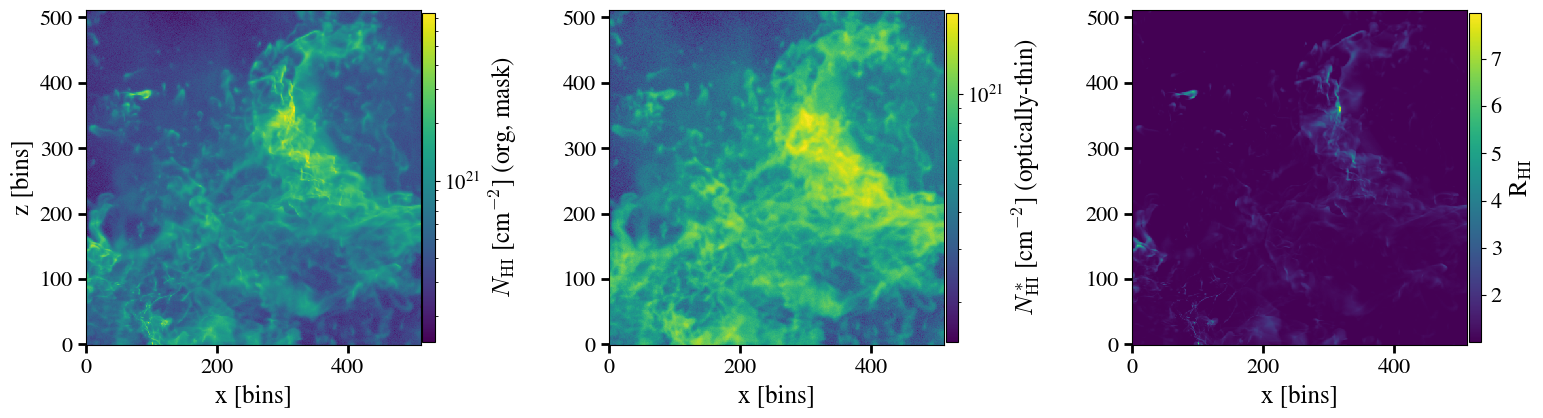

In [ ]:
xlbs = 18
tlbs = 16
cmap = 'viridis'

# Plot:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(131)


im = ax.imshow(nhi_map, origin='lower',
               cmap=cmap, norm=mpl.colors.LogNorm(),
               interpolation='none')

ax.set_ylabel(r'z [bins]', fontsize=xlbs)
ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$N_\mathrm{HI}$ [cm$^{-2}$] (org, mask)', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=15)





# ax
ax = fig.add_subplot(132)

im = ax.imshow(nhi_thin_map, origin='lower',
               cmap=cmap, norm=mpl.colors.LogNorm(),
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$N^*_\mathrm{HI}$ [cm$^{-2}$] (optically-thin)', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=15)








# ax
ax = fig.add_subplot(133)

im = ax.imshow(rhi_map, origin='lower',
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'R$_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.5,
                    hspace=0.0
                    )


plt.show()

# CNM fraction: $f_\text{CNM}$

In [ ]:
# xfile = maghi_data_path / 'fcnm_R8_2pc_300_MHD_PI_thick_175chan.fits'

fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512_thick_256chan_quarter_0.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512_thick_256chan_quarter_1.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512_thick_256chan_quarter_2.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512_thick_256chan_quarter_3.fits'

fcnm_file_q0 = saury_data_path / fcnm_file_q0
fcnm_file_q1 = saury_data_path / fcnm_file_q1
fcnm_file_q2 = saury_data_path / fcnm_file_q2
fcnm_file_q3 = saury_data_path / fcnm_file_q3

fcnm_map, hdr = fits.getdata(fcnm_file_q0, header=True)
fcnm_map.shape

(512, 512)

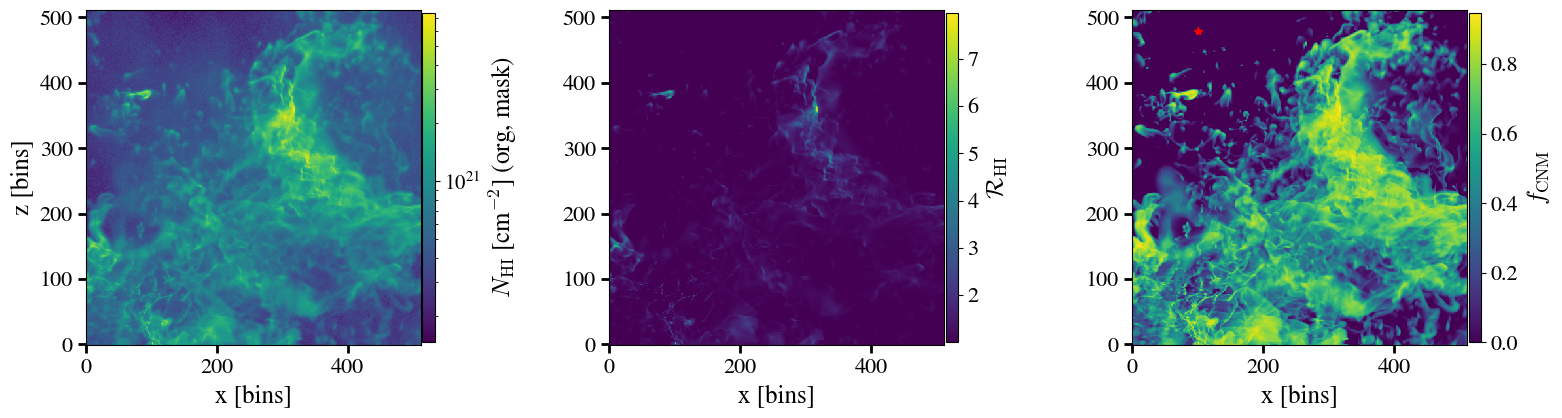

In [ ]:
xlbs = 18
tlbs = 16
cmap = 'viridis'

# Plot:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(131)


im = ax.imshow(nhi_map, origin='lower',
               cmap=cmap, norm=mpl.colors.LogNorm(),
               interpolation='none')

ax.set_ylabel(r'z [bins]', fontsize=xlbs)
ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$N_\mathrm{HI}$ [cm$^{-2}$] (org, mask)', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=15)





# ax
ax = fig.add_subplot(132)

im = ax.imshow(rhi_map, origin='lower',
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$\mathcal{R}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)








# ax
ax = fig.add_subplot(133)

im = ax.imshow(fcnm_map, origin='lower',
               cmap=cmap,
               interpolation='none')



ix = 100
jy = 480

ax.plot(ix, jy, 'r*')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.5,
                    hspace=0.0
                    )


plt.show()

# Split data cube

In [ ]:
tb_cube0 = tb_cube[:, :256, :256]
tb_cube1 = tb_cube[:, 256:, :256]
tb_cube2 = tb_cube[:, :256, 256:]
tb_cube3 = tb_cube[:, 256:, 256:]

fcnm_map0 = fcnm_map[:256, :256]
fcnm_map1 = fcnm_map[256:, :256]
fcnm_map2 = fcnm_map[:256, 256:]
fcnm_map3 = fcnm_map[256:, 256:]

rhi_map0 = rhi_map[:256, :256]
rhi_map1 = rhi_map[256:, :256]
rhi_map2 = rhi_map[:256, 256:]
rhi_map3 = rhi_map[256:, 256:]

# Preprocessing

In [ ]:
"""# GPUs or CPUs"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ngpus = torch.cuda.device_count()
print('device: ', device)
print('device_count: ', ngpus)

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print(sys.version)
print('Is CUDA enabled?', torch.cuda.is_available())

# Empty cache
torch.cuda.empty_cache()

device:  cuda
device_count:  1
Torch version:  2.5.0+cu121
torch.version.cuda:  12.1
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Is CUDA enabled? True


In [ ]:
tbcube0_arr, ymap0_arr = reshape_data(tb_cube0, [fcnm_map0, rhi_map0])
tbcube1_arr, ymap1_arr = reshape_data(tb_cube1, [fcnm_map1, rhi_map1])
tbcube2_arr, ymap2_arr = reshape_data(tb_cube2, [fcnm_map2, rhi_map2])
tbcube3_arr, ymap3_arr = reshape_data(tb_cube3, [fcnm_map3, rhi_map3])


# Concatenate along axis 0
tbcube_arr = np.concatenate((tbcube0_arr, tbcube1_arr, tbcube2_arr), axis=0)
dataset_size, nchan = tbcube_arr.shape
print('tbcube_arr: ', dataset_size, nchan)

# Concatenate along axis 0
ymap_arr = np.concatenate((ymap0_arr, ymap1_arr, ymap2_arr), axis=0)
dataset_size, nmaps = ymap_arr.shape
print('ymap_arr: ', dataset_size, nmaps)

256 256 256
256 256 256
256 256 256
256 256 256
tbcube_arr:  196608 256
ymap_arr:  196608 2


# Data Loader

In [ ]:
# dataset_size = 512 * 512
print('dataset_size: ', dataset_size)

# for training
test_len = dataset_size//5
idx_arr  = np.arange(dataset_size)
print(idx_arr)
print()
np.random.shuffle(idx_arr)
print(idx_arr)

test_idx  = idx_arr[0 : test_len]
valid_idx = idx_arr[test_len : 2*test_len]
train_idx = idx_arr[2*test_len : dataset_size]


train_len = len(train_idx)
valid_len = len(valid_idx)
test_len  = len(test_idx)
print('xy_train: ', train_len)
print('xy_vali: ', valid_len)
print('xy_test: ', test_len)
print('All: ', train_len + valid_len + test_len)
assert (train_len + valid_len + test_len == dataset_size)


tb_train = tbcube_arr[train_idx, :]
tb_valid = tbcube_arr[valid_idx, :]
tb_test  = tbcube_arr[test_idx, :]

del tbcube_arr
print('tb_train: ', tb_train.shape)
print('tb_valid: ', tb_valid.shape)
print('tb_test: ', tb_test.shape)


y_train = ymap_arr[train_idx, :]
y_valid = ymap_arr[valid_idx, :]
y_test  = ymap_arr[test_idx, :]
del ymap_arr
print('y_train: ', y_train.shape)
print('y_valid: ', y_valid.shape)
print('y_test: ', y_test.shape)

# Load models

In [ ]:
# Positional Encodings
pev_list = ['original_vector', 'index_add', 'index_concate', 'poly_concate', 'sin_add', 'sin_concate']

# Loss function
loss_fcn = CustomLoss(weights=[1., 1.])

In [ ]:
nruns   = 4
nepochs = 30

lr = 6.e-3
batch_size = 200

num_output  = nmaps
dropout     = 0.

pev = 'sin_add'
lpe = False
input_column = nchan

lrstr = str(lr).replace('.', '')
prefix = f'main_r0_{num_output}pars_{ngpus}gpus_{nruns}r{nepochs}e_{batch_size}bs_{lrstr}lr_{dataset_size//1000}k'

print(num_output)
print(dropout)
print(device)
print(prefix)

2
0.0
cuda
main_r0_2pars_1gpus_4r30e_200bs_0006lr_196k


In [ ]:
# prefix = 'trans'
print('prefix: ', prefix)

pev = 'sin_add'
input_column = 256 # number of velocity channels


# Model
cnn_trans = TPCNet(pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr)

total_params = sum(
    param.numel() for param in cnn_trans.parameters()
)

In [ ]:
# Save to csv files
trials_filename = f'{prefix}.csv'
trials_filename = training_process_path / trials_filename

all_epoches_filename = f'{prefix}_process.csv'
all_epoches_filename = training_process_path / all_epoches_filename

# Save plot
img_file_path = training_process_path / f'{prefix}_training.png'

print(trials_filename)
print(all_epoches_filename)
print(img_file_path)

In [ ]:
# saver for all epochs of all trial
all_train_err = []
all_valid_err = []
all_test_err  = []

# saver for trials/runs
run_valid_err = []
run_test_err = []

for i in range(nruns):
    print('>> Running... ', i+1, '/', nruns)

    # Model
    cnn_trans = TPCNet(pev, num_output, input_column, dropout, device, checkpoint_path, prefix, batch_size, lr)

    # Train
    epochs_train_err, epochs_valid_err, epochs_test_err, run_valid_error, run_test_error = cnn_trans.fit([tb_train, tb_valid, tb_test], [y_train, y_valid, y_test], epochs=nepochs)

    # RMSE for all epochs
    all_train_err += epochs_train_err
    all_valid_err += epochs_valid_err
    all_test_err  += epochs_test_err

    # RMSE for each trial
    run_valid_err.append(run_valid_error)
    run_test_err.append(run_test_error)



    # Save to csv file after each run
    save_csv(run_valid_err, run_test_err, trials_filename, all_train_err, all_valid_err, all_test_err, all_epoches_filename)

    # Plot
    plot(all_train_err, all_valid_err, all_test_err, prefix, img_file_path)
# End - for

print('all_train_err: ', all_train_err)
print('all_valid_err: ', all_valid_err)
print('all_test_err: ', all_test_err)

# Save MSE to csv
save_csv(run_valid_err, run_test_err, trials_filename, all_train_err, all_valid_err, all_test_err, all_epoches_filename)

# Plot
plot(all_train_err, all_valid_err, all_test_err, prefix, img_file_path)
print(img_file_path)

print('End - //')

# Prediction

In [ ]:
y_pred = cnn_trans.predict(tbcube2_arr, npars=num_output)

print('y_pred:')
print(y_pred.shape)

In [ ]:
fcnm_pred = ypred[:, 0].reshape(256, 256, order='C')
rhi_pred   = ypred[:, 1].reshape(256, 256, order='C')

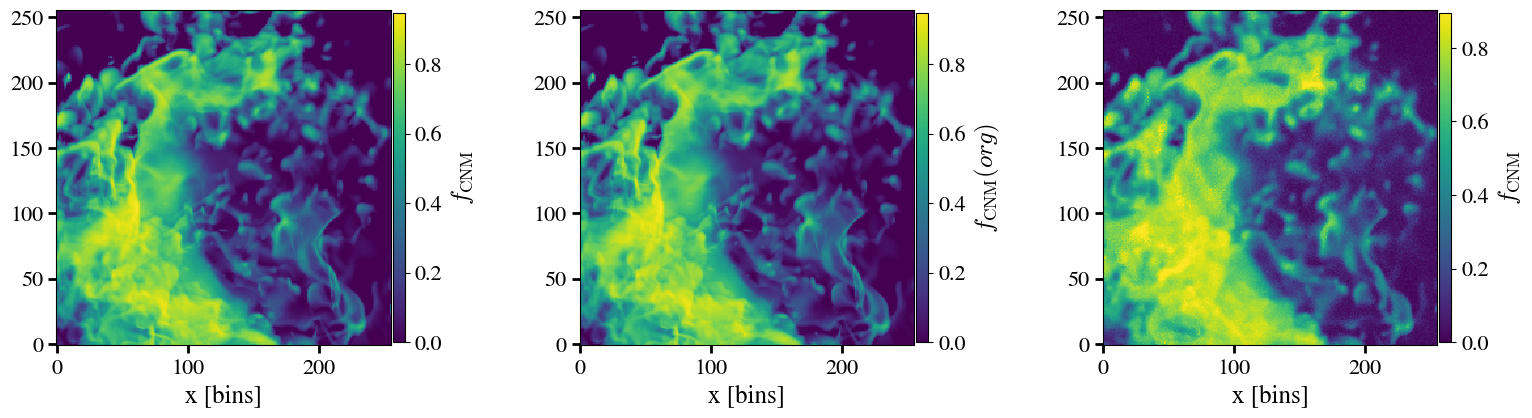

In [ ]:
xlbs = 18
tlbs = 16
cmap = 'viridis'

# Plot:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(131)


im = ax.imshow(fcnm_map3, origin='lower',
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)





# ax
ax = fig.add_subplot(132)

im = ax.imshow(fcnm_map3, origin='lower',
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM} (org)$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)








# ax
ax = fig.add_subplot(133)

im = ax.imshow(fcnm_pred, origin='lower', vmin=fcnm_map2.min(), vmax=fcnm_map2.max(),
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.5,
                    hspace=0.0
                    )


plt.show()

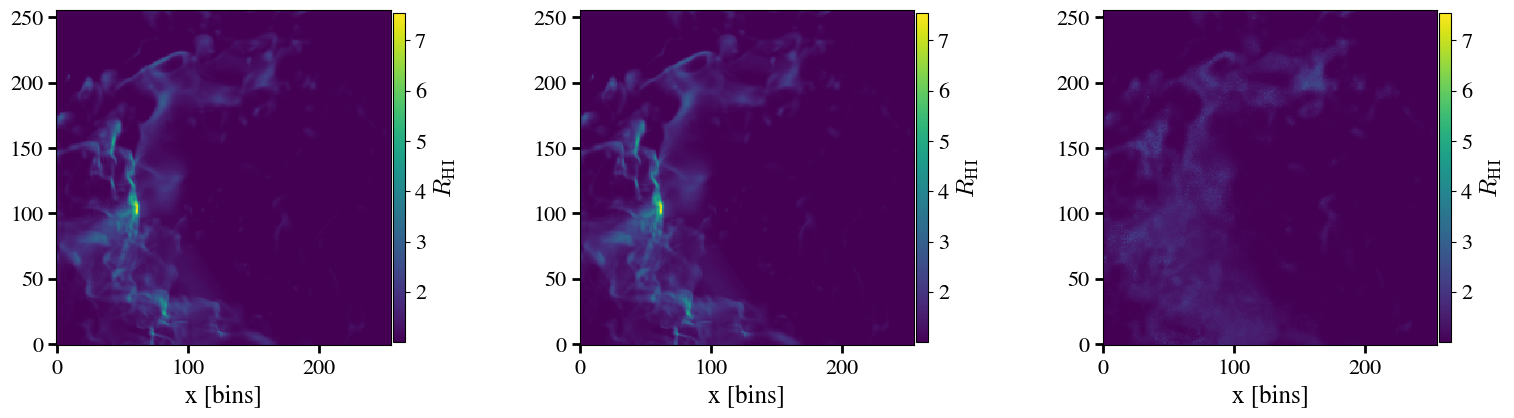

In [ ]:
xlbs = 18
tlbs = 16
cmap = 'viridis'

# Plot:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(131)


im = ax.imshow(rhi_map3, origin='lower',
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$R_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)





# ax
ax = fig.add_subplot(132)

im = ax.imshow(rhi_map3, origin='lower',
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$R_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)








# ax
ax = fig.add_subplot(133)

im = ax.imshow(rhi_pred, origin='lower', vmin=rhi_map3.min(), vmax=rhi_map3.max(),
               cmap=cmap,
               interpolation='none')

ax.set_xlabel(r'x [bins]', fontsize=xlbs)


ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.005, aspect=27)
cbar.ax.set_ylabel(r'$R_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=16)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.5,
                    hspace=0.0
                    )


plt.show()

# End